# TASK

Here attached a csv file containing a sample dataset consisting in (x, y) pairs on which you’ll have to perform a regression task. Here’s what you’ll need to do:

    1.	Open the file and read the data.
    2.	Clean the data if needed.
    3.	Plot the data.
    4.	Fit two different regression models to the data (e.g. curves belonging to two different families).
    5.	Choose a metric for the evaluation of the models and perform the evaluation using cross-validation.
    6.	Plot the predictions from the best model against the data.

We ask you to work in a Jupyter notebook specifying the versions of Python (version 3.x please) and all libraries you use: when you’re done send us the notebook and we’ll execute it and check the results. As an alternative, you can also work in a script: just make sure the results from cross-validation are printed to screen when we execute it via the terminal, and that the plots get saved as files in png format in the same directory containing the script (send us a compressed archive with the script and the plots you produced).

# ---------------------------------------------

# Analytics - Data Analytics Challenge Solution

## Introduction 

(TODO: Give a really strong introduction to the solution: we need provide a little overview of what we are required, what we will be doing to solve the problem with our own words (rephrase the problem)

## Outline 

(TODO) 

    (1) Description of the challenge
    (2) Data description 
    (3) Data visualization 
    (4) Data preprocessing -> Pipeline
    (5) Scope definition
    (6) Models definition
    (7) Model-tuning and cross-validation for optimization!
    (8) Conclusions

## (2) Dataset overview 
[TODO] In this section we are going to load the data, conduct a preliminary analysis on the main characteristics of the data provided to get a sense on how we should proceed in our analysis (data to be cleaned? standardization vs. normalization? univariate vs. bivariate analysis?)

    (1) Complete descriptions of the coding part
    (2) Provide a cleaner and nicer introduction to this section
    (2) See what we can do to perform a better analysis introducing further arguments (standardization?)

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("analytics_task_data.csv")

In [3]:
df.head()

,x,y
0,8.519119,48.073811
1,12.059918,302.657224
2,11.547357,247.531965
3,10.383055,127.686318
4,8.492261,55.086710


In [4]:
df.describe()

,x,y
count,488.000000,462.000000
mean,9.767819,133.752630
std,1.614540,91.797160
min,7.007803,10.443932
25%,8.380894,59.919619
50%,9.781597,104.201239
75%,11.122550,194.316855
max,12.498972,375.943890


In [5]:
# If there are missing values, we wish to see an overview for each column
if np.array(df.isnull().any()).any() == True: # TODO: This code might need some improvements!
    missing_data_sum = df.isnull().sum()

In [6]:
# Wish to go a little more in-depth with these missing values 

# Percentage of missings over total
print(f"""Percentage of missings over total for each column:

        x: {missing_data_sum.x/len(df.x) * 100}% \t 
        y: {missing_data_sum.y/len(df.y) * 100}% 
""")

Percentage of missings over total for each column:

        x: 2.4% 	 
        y: 7.6% 



### Handling missing values
As we have just seen, both the explanatory and the dependent variables are characterized by missing values that we need to take care of before presenting further analysis, especially before modeling. Given low percentages of data missing compared to overall size for each variable, we might want to proceed in dropping each observation, with two different approaches:

- **Explanatory variable ("x")**: they represents just a tiny fractions of the overall observations, and given the strong evidence of trend already highlighted from the data available, imputing missing values wouldn't probably improve model performance that much

- **Dependent variable ("y")**: drop the observations, but store them on an external file that eventually would work as a test data. Such procedure will enable us to visualize the results produced by two different models and see whether the latter work as expected on data that they have never seen before 

#### Handling missing values: dependent variable ("y")

In [7]:
# Retrieve indeces for null values
na_y_indeces = df.y[df.y.isnull()].index

# Store values of "x" (for which "y" is null) in a new dataframe with new keys
x_test = pd.DataFrame({"x": df.x.loc[na_y_indeces].values})

# Save the data in a new file -> analytics_task_data_test.csv
x_test.to_csv("analytics_task_data_test.csv",index=False)

# Drop these values from the original dataframe
df.dropna(axis=0,subset=["y"], inplace=True)

# Assert that all proceeded as planned
assert np.in1d(df.x,x_test.x).any() == False

#### Handling missing values: explanatory variable ("x") 

In [8]:
# Drop missing values of column "x"
df.dropna(axis=0,subset=["x"], inplace=True)

### Correlation analysis
(TODO) An important step in regression task is to see how variables are related to each other. In particular, having a simple regression task here, the only relationship we can infer from the correlation is

In [9]:
# Remove missings to calculate correlation coefficient (null values would turn down the coefficient to 0)
df_corr = df.dropna(axis=0)
# Retrieve correlation coefficient
corr_coefs = np.corrcoef(df_corr.x.values,df_corr.y.values)

print(f"Correlation between explanatory and target variable amounts to: {round(corr_coefs[0][1],2)}")

Correlation between explanatory and target variable amounts to: 0.95


The correlation between the explanatory and the target variables is really high, and this suggests us that most of the variance of the target is explained only by one predictor. The number, along with the fact that we have a relatively high number of observations, is also signaling that this relationship might be modeled quite efficiently to predict future values.

## (3) Data visualization 
[TODO: Description] Data visualization is a fundamental step in order to further explore the relationship between predictor(s) and target variable

In [10]:
# Main visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
%matplotlib inline
sns.set(color_codes=True)

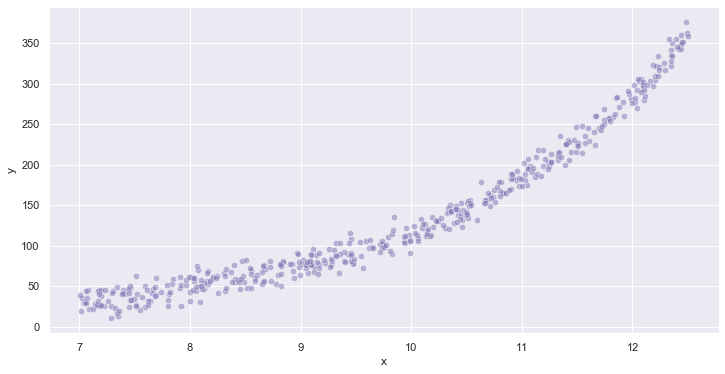

In [11]:
# First plot
plt.figure(figsize=(12,6))
sns.scatterplot(x="x",y="y",data=df,s=40,color="m",alpha=0.50)

From the graph above we can notice that indeed there is a strong relationship between explanatory and target variable. However, it seems that the relationship is non-linear, meaning that we might need something more complex to model than a simple linear regression. Indeed:

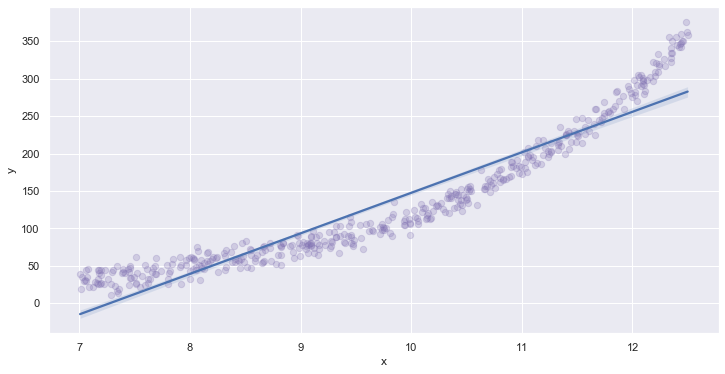

In [12]:
# Scatter-plot with fitted regression line
plt.figure(figsize=(12,6))
sns.regplot(x="x",y="y",data=df,scatter_kws={"s": 40, "color": "m","alpha": 0.25})

Here "seaborn" tried to fit a linear regression model. The result is a model which might have a relatively high score (for instance R2), but it is clearly underfitting the data, meaning that there is high chance that it is unable to predict unosberved data. In order to solve this issue, we might want to introduce high-degree polynomial regression.

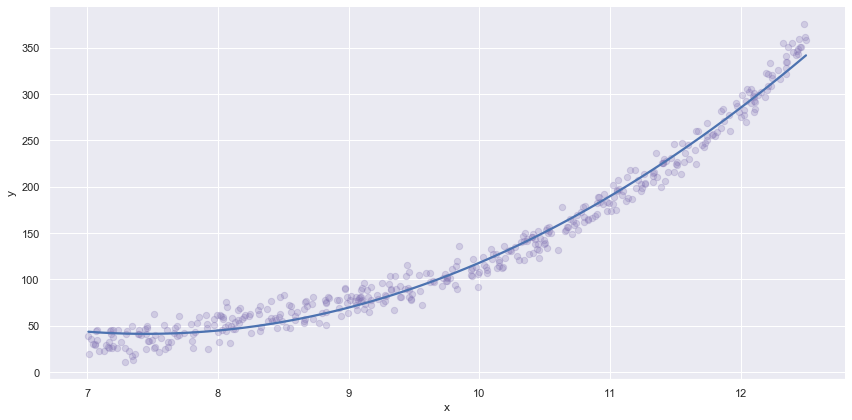

In [13]:
# Scatter-plot with high-degree polynomial regression (degree=2)
sns.lmplot(x="x", y="y", data=df, order=2, ci=None, height=6, aspect=2, scatter_kws={"s": 40, "color": "m", "alpha":0.25})

Polynomial regression seems to be way more accurate in estimating the parameters. Here we set the order of degree at 2, meaning that the equation representing the line will be a linear regression line with an additional second-degree predictor, which has the role to introduce non-linearity in the model. To conclude, from the graph above we can also notice that the line does not perfectly fit the data. Hence, the question we wish to answer at this point is: can we do better than this by increasing the polynomial order? 
(TODO: to include or not?) We will see that this is possible and it will require us to tune hyper-parameters in order to find the optimal order.

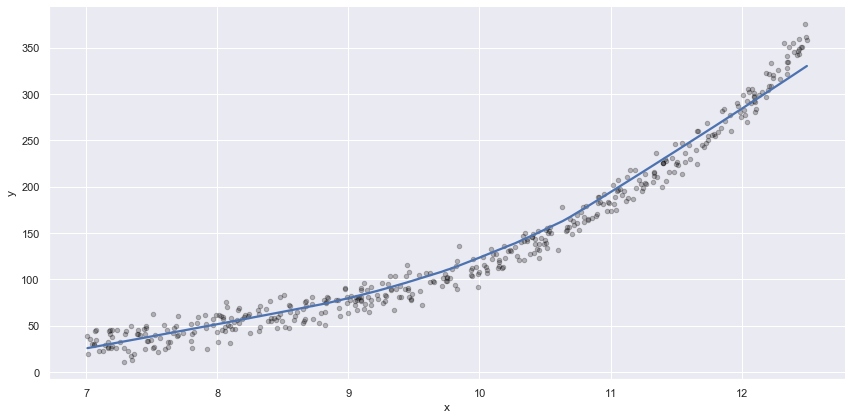

In [14]:
# [TODO: INCLUDE OR NOT?] Non-parametric regression with lowess (locally-weighted-scatterplot-smoothing) smoother
sns.lmplot(x="x", y="y", data=df, lowess=True, height=6, aspect=2, scatter_kws={"s": 20, "color": "black", "alpha":0.25})

## (4) Data preprocessing, Data Modeling, Parameter Optimizations, Cross-validation and Metrics evaluations
[TODO: Description] In this section we are going to defined two different regression models based on the analysis we conducted so far. Based on the visualizations, we already know that the relationship between the two variables is not linear, and for this reason we can exclude a linear regression model which would then underfit our data. We need to add more complexity to the models, and we do that by introducing non-linearity


#### (TODO) Is the model we picked the best we could possibly pick? We might need to twist a little the parameters in order to get the best model and at the same time we wish to take care of underfitting vs. overfitting and bias-variance trade-off issues 

#### (TODO) MSE? RMSE? How should we evaluate the model performance? This might be included in cross-valudation and optimization of hyperparameters (such as the the polynomial line or regression!)

#### (TODO) Based on the analysis we have conducted so far, we want to pick the best model that represents the relationship between the explanatory (x) and the dependent variable (y)

#### (TODO) Data preprocessing step will enable us to get our hands on the data and to correct them in order to avoid as much as possible pitfalls in modeling   

    (2) Standardization? Normalization? -> based on the data visualization analysis

In [15]:
# Build a column transformer to reshape the data for the regression. Such procedure can be directly injected to the pipeline
from sklearn.base import BaseEstimator,TransformerMixin

class ReshapeTransformer(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X.values.reshape(-1,1)

In [16]:
# Scoring metrics to compare the following models
scoring={
    "r2":"r2",
    "neg_mean_squared_error":"neg_mean_squared_error"
}

## Model 1: Polynomial Regression Model
[TODO: Description] 

In [17]:
# Libraries for this section (and the coming ones)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [18]:
# Parameters for GridSearch in polynomial regression
param_grid_poly = {
    "polynomialfeatures__degree": range(2,31) # Define a range of possible polynomial degrees (from x**2 to x**30 [high-degree polynomial])
}

In [19]:
# Pipeline for the high-degree polynomial model
def get_pipeline_poly():
    # Column reshaping transformer
    my_reshape_transformer = ReshapeTransformer()
    # Polynomial-degree transformer with a degree of 2 (parameter to be optimized sooner or later!)
    my_poly_transformer = PolynomialFeatures()
    # Define the model
    my_poly_model = LinearRegression()
    # Define and return the pipeline: bundle together data preprocessing and model definition
    return make_pipeline(my_reshape_transformer, my_poly_transformer, my_poly_model)

In [20]:
# Retrieve the optimal polynomial regression model through GridSearchCV optimization procedure
def get_optimal_poly(x=df.x,y=df.y,param_grid=param_grid_poly):
    # Retrieve the pipeline for the Gradient Boosting model
    my_poly_pipeline = get_pipeline_poly()
    # Defines Grid Search with Cross Validation on the entire pipeline given a list of parameters in order to find those minimizing the scoring
    my_poly_optimal_model = GridSearchCV(my_poly_pipeline,param_grid,cv=5,scoring=scoring,refit="r2")
    # Fits the data and finds the best parameters according to GridSearchCV
    my_poly_optimal_model.fit(x,y)
    # Return the best parameters 
    return my_poly_optimal_model

In [21]:
# Retrieve optimal model
my_poly_optimal = get_optimal_poly()

In [22]:
# Get the optimal degree for polynomial regression equation
optimal_degree = my_poly_optimal.best_params_["polynomialfeatures__degree"]

In [23]:
# Print both metrics!
poly_metrics = my_poly_optimal.cv_results_
# RMSE (Root Mean Squared Error)
print(f"Best polynomial regression model RMSE: {(-1)*max(poly_metrics['mean_test_neg_mean_squared_error'])}")
# R2 (R-Squared)
print(f"Best polynomial regression model R2: {max(poly_metrics['mean_test_r2'])}")

Best polynomial regression model RMSE: 100.86249894734247
Best polynomial regression model R2: 0.9874398493694626


## Model (2): XGBoost 
[TODO: Description] As a second model comes Gradient Boosting, which is more sophisticated with respect to a polynomial regression. Indeed, this is an ensemble model, which works by iteratively combining several base lerners with the objective of applying gradient descending algorithm to the evaluation metrics of the combined models in order to find the best resulting model. We wish to see whether we can improve our metrics on training data 

In [24]:
# Libraries for this section 
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

In [25]:
# Parameter grid containing the possible parameters values to be optimized through GridSearchCV. Each parameter will be passed through the pipeline and will be assigned where it belongs. The standard parameter name is: "pipeline_object_name__parameter"
param_grid_GB = {
    "polynomialfeatures__degree": [optimal_degree], # already optimized in the previous model
    "xgbregressor__objective": ["reg:squarederror"], 
    "xgbregressor__booster": ["gblinear"], # change GLM (Generalized Least Square) rather than tree-based learners
    "xgbregressor__learning_rate": [0.2, 0.1, 0.05, 0.01], # percentage of contribution of each new base learner 
    "xgbregressor__n_estimators": [500,1000,2000], # number of base learners iteratively trained
    "xgbregressor__early_stopping_rounds": [5], # rounds of straight deterioration allowed before stopping
}

In [26]:
def get_GB_pipeline():
    # Column reshaping transformer
    my_reshape_transformer = ReshapeTransformer()
    # MinMaxScaler on columns
    my_minmax_scaler = StandardScaler() # TODO Might be a good idea to standardize the data here to bring it to the same scale!
    # Get the proper polynomial features in the data
    my_poly_transformer = PolynomialFeatures()
    # Model
    my_GB_model = XGBRegressor()
    # Define and return the Pipeline
    return make_pipeline(my_reshape_transformer,my_minmax_scaler,my_poly_transformer,my_GB_model)

In [27]:
# Retrieve the optimal GradientBoosting model to perform predictions
def get_optimal_GB(x=df.x,y=df.y,param_grid=param_grid_GB):
    # Retrieve the pipeline for the Gradient Boosting model
    my_pipeline = get_GB_pipeline()
    # Defines Grid Search with Cross Validation on the entire pipeline given a list of parameters in order to find those minimizing the scoring
    my_GB_model = GridSearchCV(my_pipeline,param_grid,cv=5,scoring=scoring,refit="neg_mean_squared_error")
    # Fits the data and finds the best parameters according to GridSearchCV
    my_GB_model.fit(x,y)
    # Return the best parameters 
    return my_GB_model

In [28]:
# Retrieve optimal model
my_ensemble_optimal = get_optimal_GB()

In [29]:
# Print both metrics!
ensemble_metrics = my_ensemble_optimal.cv_results_
# RMSE (Root Mean Squared Error)
print(f"Best ensemble model RMSE: {(-1)*max(ensemble_metrics['mean_test_neg_mean_squared_error'])}")
# R2 (R-Squared)
print(f"Best ensemble model R2: {max(ensemble_metrics['mean_test_r2'])}")

Best ensemble model RMSE: 102.45228310655875
Best ensemble model R2: 0.9873534702075561


## (Bonus) Compare results on unseen data
[TODO] Here goes the result of the test data defined initially!

In [30]:
# Read the prepared "test" data
df_test = pd.read_csv("analytics_task_data_test.csv")

In [31]:
# Overview of the "test" data
df_test.describe()

,x
count,38.000000
mean,9.985780
std,1.685631
min,7.020344
25%,8.434214
50%,10.205881
75%,11.372476
max,12.448759


In [32]:
# Predictions

# Polynomial regression model predictions
y_preds_poly = my_poly_optimal.predict(x_test)
# Ensemble model predictions
y_preds_ensemble = my_ensemble_optimal.predict(x_test) 

<Figure size 864x576 with 0 Axes>

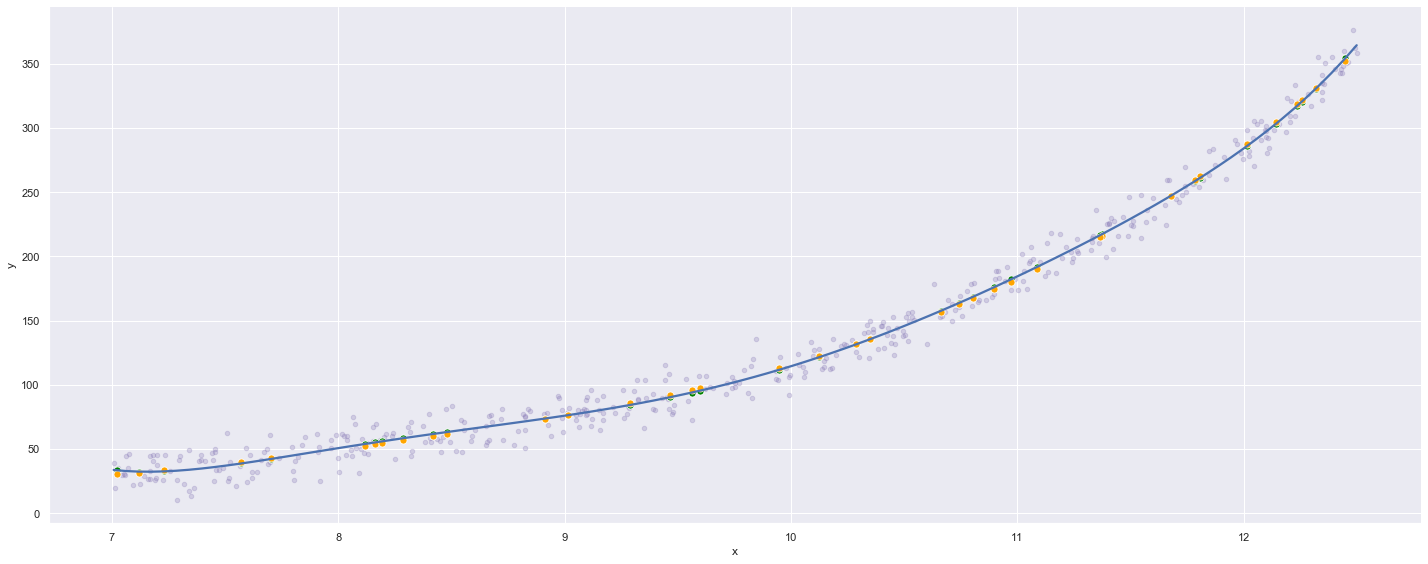

In [41]:
# Plots

# (1) Configure graph
plt.figure(figsize=(12,8))
# (2) Polynomial regression plot with the optimal degree in order to show how estimates on test data fit with our model
sns.lmplot(x="x", y="y", data=df, order=optimal_degree, ci=None, height=8, aspect=2.5, scatter_kws={"s": 20, "color": "m", "alpha":0.25})
# (3) 1st model predictions
sns.scatterplot(x=df_test.x,y=y_preds_poly, color='green', s=50)
# (4) 2nd model predictions
sns.scatterplot(x=df_test.x,y=y_preds_ensemble, color='orange', s=50)

## (8) Conclusions
#### (TODO) What can we conclude from this analysis? Write a little description summarizing the findings and how we approach a final solution

# Additional content! 

Common end-to-end ML project schedule to take inspirations from

    (1) Look at the Big Picture
            Frame the Problem
            Select a Performance Measure
            Check the Assumptions
    (2) Get the Data
            Create the Workspace
            Download the Data
            Take a Quick Look at the Data Structure
            Create a Test Set
    (3) Discover and Visualize the Data to Gain Insights
            Visualizing Geographical Data
            Looking for Correlations
            Experimenting with Attribute Combinations
    (4) Prepare the Data for Machine Learning Algorithms
            Data Cleaning
            Handling Text and Categorical Attributes
            Custom Transformers
            Feature Scaling
            Transformation Pipelines
    (5) Select and Train a Model
            Training and Evaluating on the Training Set
            Better Evaluation Using Cross-Validation
    (6) Fine-Tune Your Model
            Grid Search
            Randomized Search
            Ensemble Methods (Random forest and Gradient Boosting)
            Analyze the Best Models and Their Errors
            Evaluate Your System on the Test Set
